In [30]:
!pip install statsforecast
!pip install pmdarima

In [31]:
import requests
import json
import pandas as pd
import IPython
import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import os
import datetime
import tensorflow as tf
import io
import scipy
import sklearn
import keras
from scipy.signal import detrend
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import pmdarima as pm
from pmdarima import AutoARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [78]:
ticker = "IBM"
API_KEY = 'demo'
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY_ADJUSTED&symbol=' + ticker + '&apikey=' + API_KEY + '&datatype=csv'
r = requests.get(url).content
data = pd.read_csv(io.StringIO(r.decode('utf-8')))
data.head()

,timestamp,open,high,low,close,adjusted close,volume,dividend amount
0,2024-04-30,167.40,168.22,165.2605,166.20,166.20,11274976,0.0
1,2024-04-26,182.45,184.68,165.6600,167.13,167.13,42329269,0.0
2,2024-04-19,185.57,187.48,180.1700,181.58,181.58,16929550,0.0
3,2024-04-12,189.24,191.25,181.6850,182.27,182.27,14955313,0.0
4,2024-04-05,190.00,193.28,187.3400,189.14,189.14,12808073,0.0


In [79]:
url2 = 'https://www.alphavantage.co/query?function=FEDERAL_FUNDS_RATE&interval=monthly&apikey=' + API_KEY
r = requests.get(url2)
interest = r.json()
intr_df = pd.json_normalize(interest['data'], meta=['date','value'])
intr_df.columns = ['timestamp', 'interest rate']
intr_df['timestamp'] = pd.to_datetime(intr_df['timestamp'], format='%Y-%m-%d')
intr_df.head()

,timestamp,interest rate
0,2024-03-01,5.33
1,2024-02-01,5.33
2,2024-01-01,5.33
3,2023-12-01,5.33
4,2023-11-01,5.33


In [80]:
url3 = 'https://www.alphavantage.co/query?function=INFLATION&apikey=' + API_KEY
r = requests.get(url3)
inflation = r.json()
infl_df = pd.json_normalize(inflation['data'], meta=['date','value'])
infl_df.columns = ['timestamp', 'inflation rate']
infl_df['timestamp'] = pd.to_datetime(infl_df['timestamp'], format='%Y-%m-%d')
infl_df.head()

,timestamp,inflation rate
0,2022-01-01,8.00279982052121
1,2021-01-01,4.69785886363742
2,2020-01-01,1.23358439630629
3,2019-01-01,1.81221007526021
4,2018-01-01,2.44258329692817


In [81]:
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d')
data = data.drop(index=0)
data.describe().transpose()
timestamps = data['timestamp'].copy().to_frame()
del data['dividend amount']
data.head()

,timestamp,open,high,low,close,adjusted close,volume
1,2024-04-26,182.45,184.6800,165.660,167.13,167.13,42329269
2,2024-04-19,185.57,187.4800,180.170,181.58,181.58,16929550
3,2024-04-12,189.24,191.2500,181.685,182.27,182.27,14955313
4,2024-04-05,190.00,193.2800,187.340,189.14,189.14,12808073
5,2024-03-28,190.26,191.9299,188.500,190.96,190.96,15383298


In [82]:
data = data.sort_values(by=['timestamp'])
intr_df = intr_df.sort_values(by=['timestamp'])
infl_df = infl_df.sort_values(by=['timestamp'])

data = pd.merge_asof(data, intr_df, on='timestamp', direction='backward')
data = pd.merge_asof(data, infl_df, on='timestamp', direction='backward')

data['box-cox close'], lmbd = stats.boxcox(data['adjusted close'])

t_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
v_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
r1_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
r2_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))

data['scaled close'] = t_scaler.fit_transform(data['box-cox close'].to_numpy().reshape(-1, 1))
data['scaled volume'] = v_scaler.fit_transform(data['volume'].to_numpy().reshape(-1, 1))
data['scaled interest'] = r1_scaler.fit_transform(data['interest rate'].to_numpy().reshape(-1, 1))
data['scaled inflation'] = r2_scaler.fit_transform(data['inflation rate'].to_numpy().reshape(-1, 1))


data.tail()

,timestamp,open,high,low,close,adjusted close,volume,interest rate,inflation rate,box-cox close,scaled close,scaled volume,scaled interest,scaled inflation
1272,2024-03-28,190.26,191.9299,188.500,190.96,190.96,15383298,5.33,8.00279982052121,20.880695,0.979890,0.073818,0.813559,1.0
1273,2024-04-05,190.00,193.2800,187.340,189.14,189.14,12808073,5.33,8.00279982052121,20.782703,0.972482,0.048846,0.813559,1.0
1274,2024-04-12,189.24,191.2500,181.685,182.27,182.27,14955313,5.33,8.00279982052121,20.408001,0.944157,0.069668,0.813559,1.0
1275,2024-04-19,185.57,187.4800,180.170,181.58,181.58,16929550,5.33,8.00279982052121,20.369936,0.941279,0.088811,0.813559,1.0
1276,2024-04-26,182.45,184.6800,165.660,167.13,167.13,42329269,5.33,8.00279982052121,19.553477,0.879560,0.335107,0.813559,1.0


<Axes: ylabel='close'>

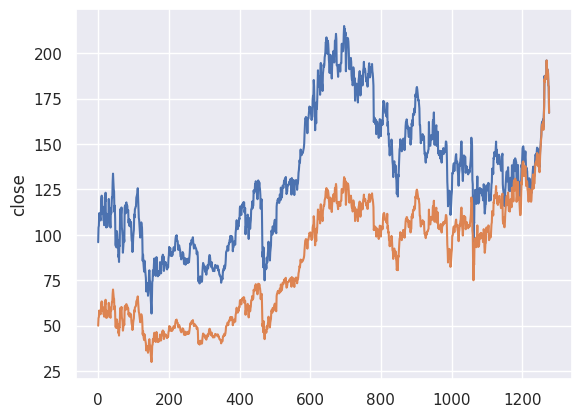

In [83]:
sns.lineplot(data['close'])
sns.lineplot(data['adjusted close'])

In [84]:
data = data.sort_values(by=['timestamp'], ascending=False)

In [85]:
#Add box-cox transformation, could be better than detrended for svm
#research input for lstm

#detrended = detrend(data['scaled close'], type='linear')
#dtr_df = pd.DataFrame(detrended, index=data.index, columns=['detrended close'])
#data = data.merge(dtr_df, on=data.index)
data = data.iloc[::-1]
data.index = data['timestamp']
timestamp_copy = data['timestamp'].copy()
del data['timestamp']

data.head()

,open,high,low,close,adjusted close,volume,interest rate,inflation rate,box-cox close,scaled close,scaled volume,scaled interest,scaled inflation
timestamp,,,,,,,,,,,,,
1999-11-12,90.50,97.50,90.50,95.87,49.9288,43569700,5.42,2.18802719697358,10.511164,0.196015,0.347135,0.827427,0.304315
1999-11-19,96.00,105.12,92.62,103.94,54.1316,61550800,5.42,2.18802719697358,10.976773,0.231213,0.521493,0.827427,0.304315
1999-11-26,105.50,109.87,101.81,105.00,54.6837,37165600,5.42,2.18802719697358,11.036421,0.235722,0.285036,0.827427,0.304315
1999-12-03,104.94,112.87,102.12,111.87,58.2615,37670000,5.30,2.18802719697358,11.415079,0.264346,0.289927,0.808937,0.304315
1999-12-10,113.00,122.12,107.56,109.00,56.7668,58626000,5.30,2.18802719697358,11.258508,0.252510,0.493132,0.808937,0.304315


In [86]:
i = int(len(data)*0.7)
j = int(len(data)*0.9)
train = data[0:i]
val = data[i:j]
test = data[j:]

In [87]:
train.head()

,open,high,low,close,adjusted close,volume,interest rate,inflation rate,box-cox close,scaled close,scaled volume,scaled interest,scaled inflation
timestamp,,,,,,,,,,,,,
1999-11-12,90.50,97.50,90.50,95.87,49.9288,43569700,5.42,2.18802719697358,10.511164,0.196015,0.347135,0.827427,0.304315
1999-11-19,96.00,105.12,92.62,103.94,54.1316,61550800,5.42,2.18802719697358,10.976773,0.231213,0.521493,0.827427,0.304315
1999-11-26,105.50,109.87,101.81,105.00,54.6837,37165600,5.42,2.18802719697358,11.036421,0.235722,0.285036,0.827427,0.304315
1999-12-03,104.94,112.87,102.12,111.87,58.2615,37670000,5.30,2.18802719697358,11.415079,0.264346,0.289927,0.808937,0.304315
1999-12-10,113.00,122.12,107.56,109.00,56.7668,58626000,5.30,2.18802719697358,11.258508,0.252510,0.493132,0.808937,0.304315


In [88]:
def create_dataset(dataset, features, targets, seq_len=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-seq_len-1):
  a = dataset[features].to_numpy()[i:(i+seq_len), 0]
  dataX.append(a)
  dataY.append(dataset[targets].to_numpy()[i + seq_len, 0])
 return np.array(dataX), np.array(dataY)

In [89]:
FEATURES = ['scaled close']
#, 'scaled volume', 'scaled interest', 'scaled inflation'
TARGET = ['scaled close']

train_timestamps = timestamp_copy[:i]
val_timestamps = timestamp_copy[i:j]
test_timestamps = timestamp_copy[j:]
column_names = train.columns

seq_len = 16

#train data
train_ds = keras.utils.timeseries_dataset_from_array(train[FEATURES][:-1*seq_len].to_numpy().astype('float32'), train[TARGET][seq_len:].to_numpy().astype('float32'), sequence_length=seq_len)
#x_train, y_train = create_dataset(train, FEATURES, TARGET, seq_len)
#x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(FEATURES)))


#x_train = train[FEATURES].to_numpy().astype('float32').reshape((len(train),1,len(FEATURES)))
#y_train = train[TARGET].to_numpy().astype('float32').reshape((len(train),1,1))

#validation data
val_ds = keras.utils.timeseries_dataset_from_array(val[FEATURES][:-1*seq_len].to_numpy().astype('float32'), val[TARGET][seq_len+1:].to_numpy().astype('float32'), sequence_length=seq_len)
#x_val, y_val = create_dataset(val, FEATURES, TARGET, seq_len)
#x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], len(FEATURES)))

#x_val = val[FEATURES].to_numpy().astype('float32').reshape((len(val),1,len(FEATURES)))
#y_val = val[TARGET].to_numpy().astype('float32').reshape((len(val),1,1))

#test data
test_ds = keras.utils.timeseries_dataset_from_array(test[FEATURES][:-1*seq_len].to_numpy().astype('float32'), test[TARGET][seq_len+1:].to_numpy().astype('float32'), sequence_length=seq_len)
#x_test, y_test = create_dataset(test, FEATURES, TARGET, seq_len)
#x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(FEATURES)))

#x_test = test[FEATURES].to_numpy().astype('float32').reshape((len(test),1,len(FEATURES)))
#y_test = test[TARGET].to_numpy().astype('float32').reshape((len(test),1,1))

In [ ]:
## LSTM MODEL ##

#Try to make more accurate after finishing other models
MAX_EPOCHS = 1000

lstm_model = tf.keras.models.Sequential()

lstm_model.add(tf.keras.Input(shape=(seq_len, len(FEATURES))))

#lstm_model.add(tf.keras.layers.LSTM(32, return_sequences=True, recurrent_dropout=0.1))
#lstm_model.add(tf.keras.layers.Dense(units=128, activation='tanh'))

lstm_model.add(tf.keras.layers.LSTM(32, return_sequences=True, recurrent_dropout=0.1))
#lstm_model.add(tf.keras.layers.Dense(units=32, activation='tanh'))

lstm_model.add(tf.keras.layers.LSTM(32, return_sequences=True, recurrent_dropout=0.2))
#lstm_model.add(tf.keras.layers.Dense(units=32, activation='tanh'))

lstm_model.add(tf.keras.layers.LSTM(32, return_sequences=False, recurrent_dropout=0.3))
#lstm_model.add(tf.keras.layers.Dense(units=32, activation='tanh'))

#lstm_model.add(tf.keras.layers.Dense(units=32, activation='tanh'))
#lstm_model.add(tf.keras.layers.Dense(units=8, activation='tanh'))
lstm_model.add(tf.keras.layers.Dense(units=1, activation='linear'))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
history = lstm_model.fit(train_ds, epochs=MAX_EPOCHS, validation_data=val_ds, shuffle=False)#, callbacks=[early_stopping])



<Axes: >

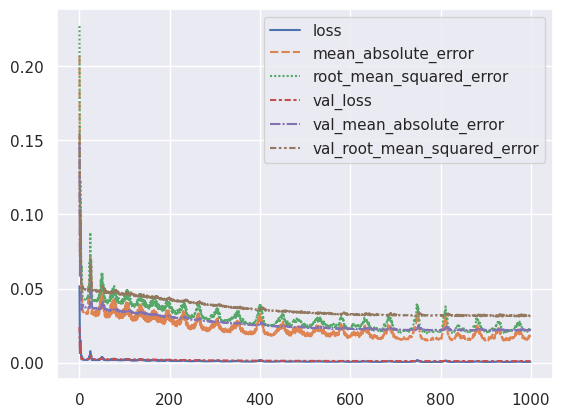

In [45]:
losses = pd.DataFrame(history.history)
sns.lineplot(losses)

In [46]:
test_loss, test_mae, test_rmse = lstm_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Mean Absolute Error:", test_mae)
print("Test Root Mean Squared Error:", test_rmse)

1/1 [==============================] - 0s 109ms/step - loss: 0.0017 - mean_absolute_error: 0.0332 - root_mean_squared_error: 0.0412
Test Loss: 0.001696823164820671
Test Mean Absolute Error: 0.0331888347864151
Test Root Mean Squared Error: 0.04119251295924187


In [ ]:
lstm_preds = lstm_model.predict(test_ds)
print(lstm_preds)

<Axes: xlabel='timestamp', ylabel='scaled close'>

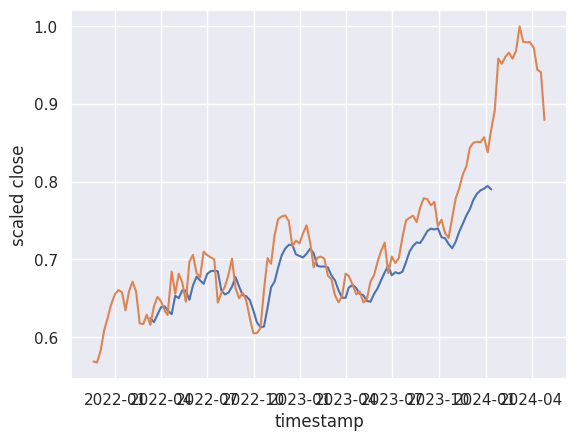

In [71]:
sns.set_theme()

difference = len(test) - len(lstm_preds)

endpoint = difference - seq_len

sns.lineplot(y=lstm_preds.flatten(), x=test_timestamps[seq_len:-1*endpoint])
sns.lineplot(test['scaled close'])

97

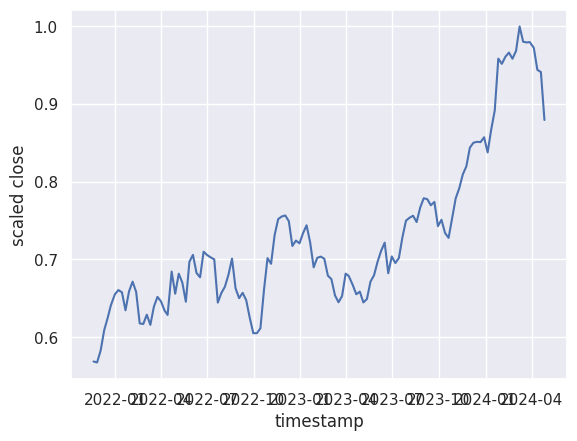

In [72]:
sns.lineplot(y=test['scaled close'], x=test_timestamps)
#sns.lineplot(x=test.index[16:], y=lstm_preds.flatten())
len(lstm_preds)
#len(test)

In [90]:
## SVM REGRESSION MODEL ##

from sklearn import svm
svm_model = sklearn.svm.SVR()
svm_model.fit(train[FEATURES][:-1].values, train['scaled close'][1:].values.flatten())

SVR()

<Axes: xlabel='timestamp', ylabel='scaled close'>

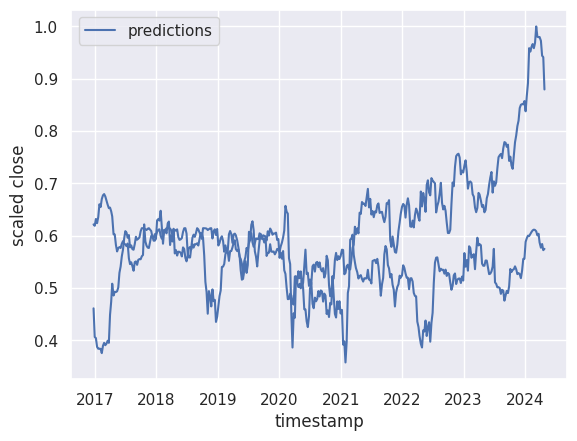

In [91]:
sklearn_test = data[i:]
sklearn_timestamps = sklearn_test.index
svm_preds = svm_model.predict(sklearn_test[FEATURES].values)
svm_preds = svm_preds[::-1]
svm_df = pd.DataFrame(svm_preds, index=sklearn_test.index, columns=['predictions'])

sns.set_theme()
sns.lineplot(sklearn_test['scaled close'])
sns.lineplot(svm_df)


In [92]:
## ADF TEST ##
adfuller(train['scaled close'])

(-0.7630079008644822,
 0.8297475105662413,
 5,
 887,
 {'1%': -3.437743827988169,
  '5%': -2.864803950716061,
  '10%': -2.5685079558676054},
 -4645.542661266118)

In [93]:
## ARIMA MODEL ##
arima_model = AutoARIMA()
train.index = pd.DatetimeIndex(train.index).to_period('W')
fitted = arima_model.fit(train['scaled close'])

In [94]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  893
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2375.945
Date:                Wed, 01 May 2024   AIC                          -4747.890
Time:                        14:35:31   BIC                          -4738.303
Sample:                    11-14-1999   HQIC                         -4744.226
                         - 12-18-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0626      0.028     -2.210      0.027      -0.118      -0.007
sigma2         0.0003   8.47e-06     33.593      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               386.64
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
test_features = ['scaled inflation','scaled interest','scaled volume']
sklearn_test.index = pd.DatetimeIndex(sklearn_test.index).to_period('W')
#arima_preds = fitted.predict(n_periods=len(sklearn_test), return_conf_int=True)


In [96]:
arima_history = [x for x in train['scaled close']]
arima_preds = list()
for t in range(len(sklearn_test)):
 model = ARIMA(arima_history, order=(1,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 arima_preds.append(yhat)
 obs = sklearn_test['scaled close'][t]
 arima_history.append(obs)

from sklearn.metrics import mean_squared_error
import math

arima_rmse = math.sqrt(mean_squared_error(sklearn_test['scaled close'], arima_preds))

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [97]:
print(arima_rmse)

0.021076203320662353


<Axes: xlabel='timestamp', ylabel='scaled close'>

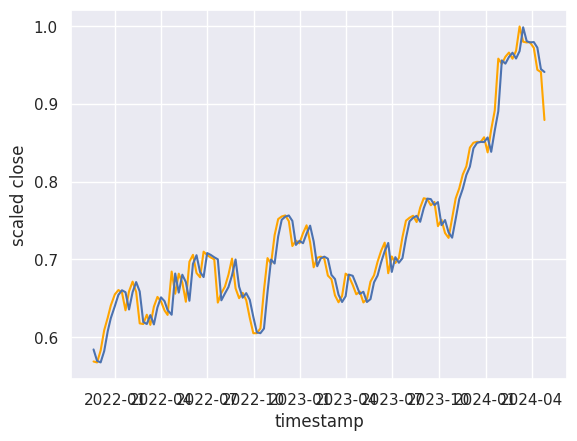

In [128]:
sns.lineplot(y=data['scaled close'][j:], x=test_timestamps, color='orange')
sns.lineplot(y=arima_preds[len_diff:], x=test_timestamps)

In [105]:
svm_rmse = math.sqrt(mean_squared_error(sklearn_test['scaled close'], svm_preds))
print(svm_rmse)

0.14886032377842173


<Axes: xlabel='timestamp', ylabel='scaled close'>

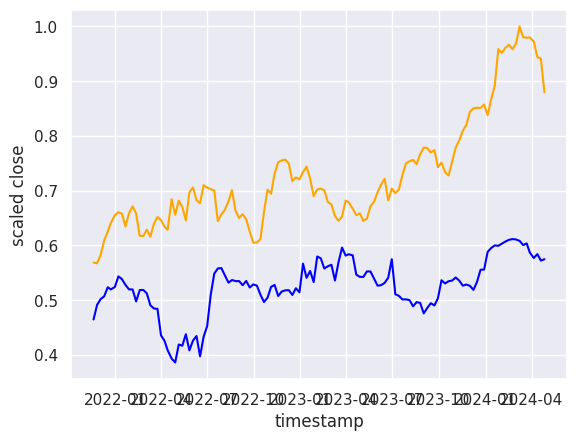

In [129]:
sns.lineplot(y=data['scaled close'][j:], x=test_timestamps, color='orange')
len_diff = len(sklearn_test)-len(test)
sns.lineplot(y=svm_df.to_numpy().flatten()[len_diff:], x=test_timestamps, color='blue')


In [125]:
test.head()

,open,high,low,close,adjusted close,volume,interest rate,inflation rate,box-cox close,scaled close,scaled volume,scaled interest,scaled inflation
timestamp,,,,,,,,,,,,,
2021-11-19,119.54,120.16,115.27,116.05,104.3072,24272797,0.08,4.69785886363742,15.441170,0.568694,0.160017,0.004622,0.604594
2021-11-26,116.00,118.81,114.56,115.81,104.0915,17875027,0.08,4.69785886363742,15.424941,0.567467,0.097979,0.004622,0.604594
2021-12-03,118.62,119.61,116.45,118.84,106.8149,36059651,0.08,4.69785886363742,15.628491,0.582855,0.274312,0.004622,0.604594
2021-12-10,119.40,125.33,119.40,124.09,111.5337,25031512,0.08,4.69785886363742,15.974451,0.609007,0.167374,0.004622,0.604594
2021-12-17,123.76,128.64,120.79,127.40,114.5087,35216850,0.08,4.69785886363742,16.188390,0.625180,0.266139,0.004622,0.604594
